In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

print(tf.__version__)


1.12.0


## Preprocess images

In [2]:
#folder = 'C:\\Users\\Sur lab\\Documents\\allenCCF3\\Data\\MouseC07'
folder = 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Leica\\C07_LMN_092018_disynaptic_STRACC_mCherry_10x'
#folder = 'C:\\Users\\Sur lab\\Documents\\allenCCF3\\Data\\MouseC07\\Raw'
files = glob.glob(folder + '\\*\\*ch00.tif')

In [3]:
order = np.array([0, 2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 11,
                 12, 14, 16, 18, 20, 13, 15, 17, 19, 21,
                 22, 24, 26, 28, 30, 32, 23, 25, 27, 29, 31, 33,
                 34, 38, 42, 46, 50, 51, 52, 53,
                 35, 36, 37, 39, 40, 41, 43, 44, 45, 47, 48, 49, 55, 56])

In [4]:
def augment(image, nrotate, ncrop):
    '''Given an image, augment by nrotate * ncrop * 2 times'''
    

In [67]:
# Load image labels
zcoords = pd.read_csv('human_label_APcoords.csv')
zcoords = zcoords[zcoords.AP < 100].AP
zcoords = np.array(zcoords)

In [14]:
# Load images
bad_images = [38, 40, 44, 48, 52, 55, 59, 60, 61, 62]
flipped_images = [26, 36, 37, 41, 42, 45, 46, 49, 50, 56, 57]
all_images = np.zeros((51 * 120, 80, 100, 1))
naugment = 50
imsize = (100, 80)

count = 0
imlst = []
for i in range(len(order)):
    if order[i] + 1 in bad_images:
        continue
    
    im = Image.open(files[order[i]])
    imresize = im.resize(imsize, Image.ANTIALIAS)
    #imarr = np.array(imresize)
    if order[i] + 1 in flipped_images:
        imresize = imresize.transpose(Image.FLIP_TOP_BOTTOM)
        
    # Save image
    filename = files[order[i]]
    pos1 = str.index(filename, 'slice')
    pos2 = str.index(filename, 'slice', pos1 + 1)
    
    #imresize.save('C07_small/C07_im' + str(i) + '_' + filename[pos2:])
 

       
    # Data augmentation
    for i in range(naugment):
        # Pick a random angle
        angle = np.random.rand() * 40 - 20
        ver_crop = np.random.rand() * 40 - 20
        hor_crop = np.random.rand() * 40 - 20
        
        modified1 = imresize.rotate(angle).crop((ver_crop, hor_crop, \
                                                 ver_crop+imsize[0], hor_crop+imsize[1]))
        modified2 = modified1.transpose(Image.FLIP_LEFT_RIGHT)
        
        modified1 = np.array(modified1)[:,:,np.newaxis] / 256
        modified2 = np.array(modified2)[:,:,np.newaxis] / 256
        
        imlst += [modified1, modified2]
        #print(modified1.shape, modified2.shape)
        
    #all_images[count] = imarr[:,:,np.newaxis] / 256
    
    #count += 1
    #plt.imshow(imarr, aspect='auto')
    #imlst.append(imarr)
    
    

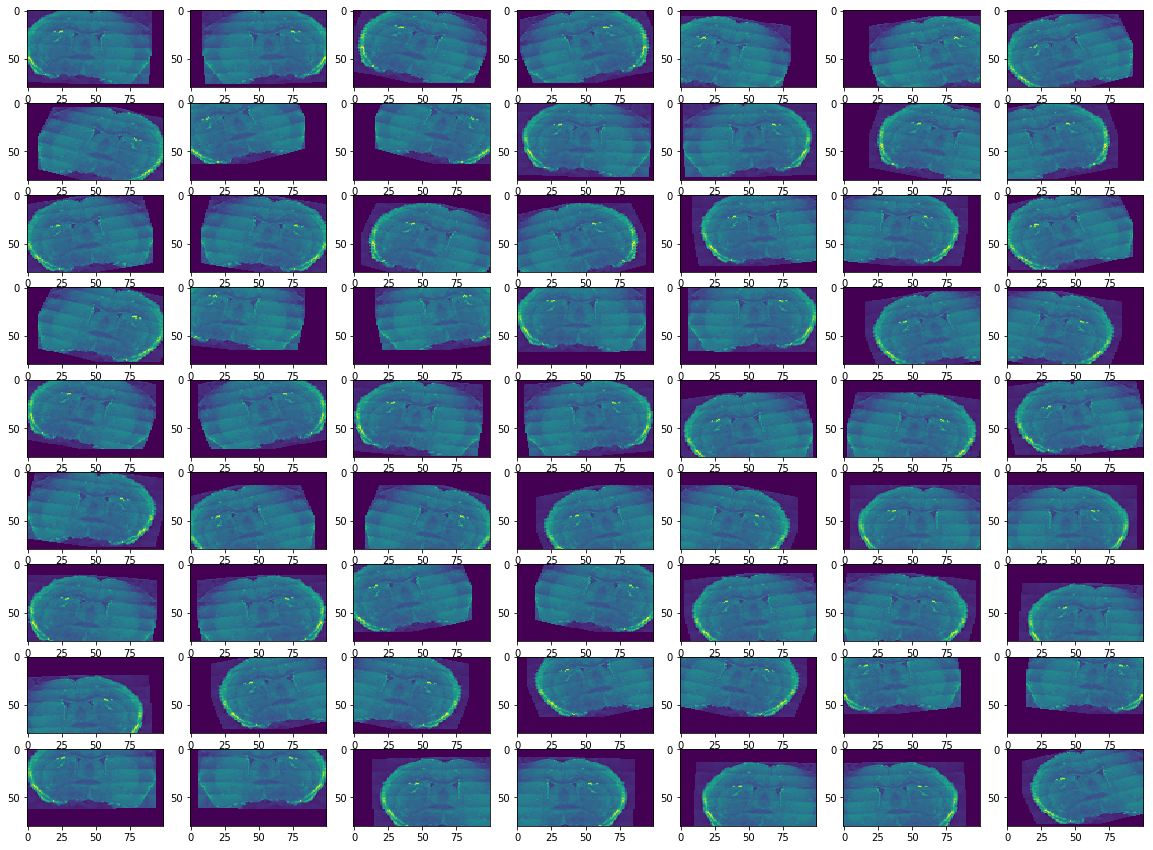

In [68]:
all_images = np.array(imlst)
plt.figure(figsize=(20,15))
for i in range(63):
    plt.subplot(9, 7, i + 1)
    plt.imshow(all_images[i + 2000,:,:,0], aspect='auto')
    
#zcoords = np.linspace(1.98, -2.9, 51)
zcoords = zcoords.repeat(100)


In [69]:
# Now randomize the array
nimages = all_images.shape[0]
ntrain = int(nimages * 0.7)
nval = int(nimages * 0.2)
ntest = nimages - ntrain - nval

order = np.arange(nimages)
np.random.shuffle(order)

shuffled_images = all_images[order]
shuffled_coords = zcoords[order]

train_images = shuffled_images[:ntrain]
train_coords = shuffled_coords[:ntrain]
val_images = shuffled_images[ntrain:(ntrain + nval)]
val_coords = shuffled_coords[ntrain:(ntrain + nval)]
test_images = shuffled_images[ntrain+nval:]
test_coords = shuffled_coords[ntrain+nval:]

In [72]:
np.unique(zcoords)

array([-3.1e+00, -3.0e+00, -2.9e+00, -2.8e+00, -2.7e+00, -2.6e+00,
       -2.5e+00, -2.4e+00, -2.3e+00, -2.2e+00, -2.1e+00, -9.0e-01,
       -8.0e-01, -7.0e-01, -6.0e-01, -5.0e-01, -4.0e-01, -3.0e-01,
       -2.0e-01, -1.0e-01,  1.0e-03,  5.0e-02,  1.0e-01,  1.5e-01,
        2.0e-01,  2.5e-01,  3.0e-01,  4.0e-01,  5.0e-01,  6.0e-01,
        1.0e+00,  1.1e+00,  1.2e+00,  1.3e+00,  1.4e+00,  1.5e+00,
        1.6e+00,  1.7e+00,  1.8e+00,  1.9e+00,  2.0e+00,  2.1e+00,
        2.2e+00,  2.3e+00,  2.4e+00])

-2.6


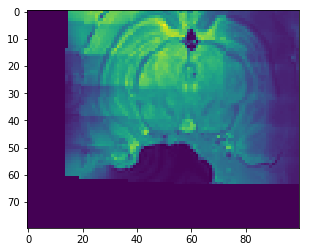

In [71]:
id = 700
plt.imshow(train_images[id][:,:,0])
print(train_coords[id])

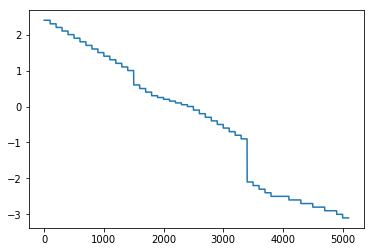

In [49]:
plt.plot(zcoords)

In [64]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1),
                            activation='relu', input_shape=(80,100,1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

In [73]:
sgd = keras.optimizers.SGD(lr=0.1, clipnorm=1.)
adagrad = tf.train.AdagradOptimizer(learning_rate=10)
adam = tf.train.AdamOptimizer(learning_rate=10)
model.compile(optimizer= adam, 
              loss='mean_squared_error')

model.fit(train_images, train_coords, epochs=2)

Epoch 1/2
3570/3570 [==============================] - 27s 8ms/step - loss: nan
Epoch 2/2
3570/3570 [==============================] - 27s 7ms/step - loss: nan


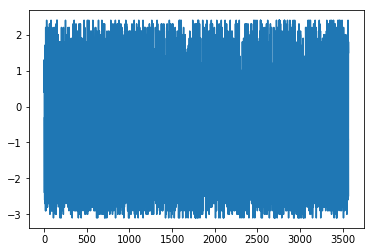

In [66]:
plt.plot(train_coords)

In [54]:
prediction_val

array([[-0.4358383],
       [-0.4358383],
       [-0.4358383],
       ...,
       [-0.4358383],
       [-0.4358383],
       [-0.4358383]], dtype=float32)

C:\Anaconda3\envs\tflow\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


RMS error is nan


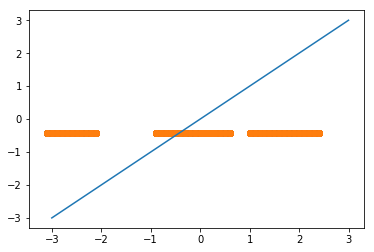

In [53]:
prediction = model.predict(train_images)


plt.scatter(train_coords, prediction)

prediction_val = model.predict(val_images)
plt.scatter(val_coords, prediction_val, alpha=0.5)

plt.plot([-3, 3], [-3, 3])

err = prediction_val.flatten() - val_coords
print('RMS error is', np.sqrt(np.mean(err)))

## Example of fashion images just to get started

In [14]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [15]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [16]:
train_images.shape

(60000, 28, 28)

In [17]:
len(train_labels)


60000

In [18]:
test_images.shape

(10000, 28, 28)

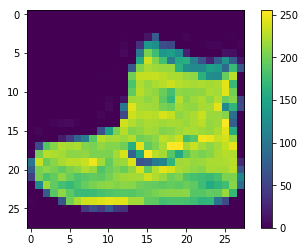

In [19]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)


In [20]:
train_images = train_images / 255.0

test_images = test_images / 255.0


In [21]:
layer = tf.keras.layers.Dense(32)

In [22]:
layer.get_config()

{'name': 'dense_2',
 'trainable': True,
 'dtype': None,
 'units': 32,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None, 'dtype': 'float32'}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

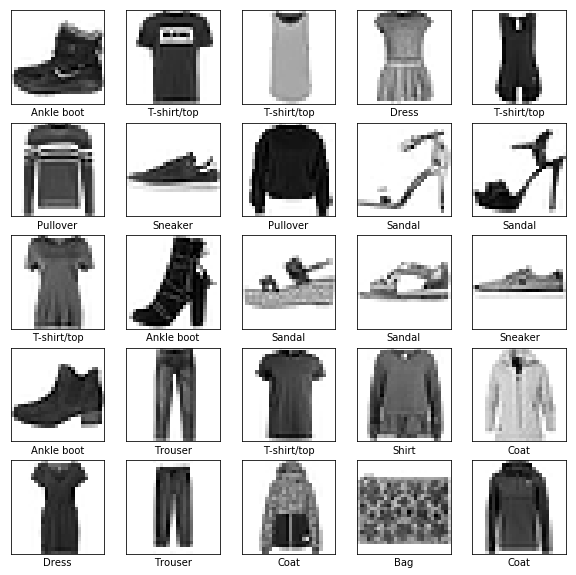

In [23]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])


In [24]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.softmax)
])


In [25]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mean_squared_error',
              metrics=['accuracy'])


In [26]:
model.compile?

In [27]:
model.fit(train_images, train_labels, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 2s 37us/step - loss: 20.5000 - acc: 0.1000
Epoch 2/5
60000/60000 [==============================] - 2s 34us/step - loss: 20.5000 - acc: 0.1000
Epoch 3/5
60000/60000 [==============================] - 2s 35us/step - loss: 20.5000 - acc: 0.1000
Epoch 4/5
60000/60000 [==============================] - 2s 34us/step - loss: 20.5000 - acc: 0.1000
Epoch 5/5
60000/60000 [==============================] - 2s 34us/step - loss: 20.5000 - acc: 0.1000


In [28]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)


10000/10000 [==============================] - 0s 22us/step
Test accuracy: 0.1


In [29]:
predictions = model.predict(test_images)


In [30]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


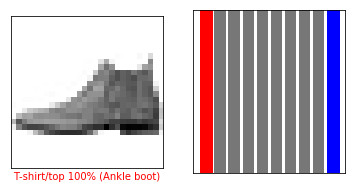

In [31]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
